In [1]:
# Install required libraries
!pip install transformers tqdm

import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm.notebook import tqdm

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()


/Users/chandhanu/Documents/GitHub/Topics-in-AI-Project-598/myenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/chandhanu/Documents/GitHub/Topics-in-AI-Project-598/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:

def compute_likelihood(sentence, context=None):
    if context:
        input_text = context + ' ' + sentence
    else:
        input_text = sentence

    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    with torch.no_grad():
        outputs = model(input_ids)
        log_likelihood = outputs[0][0, :-1].gather(1, input_ids[0, 1:].unsqueeze(-1)).sum().item()

    return log_likelihood

def calculate_sequentiality(story, summary, memtype):
    sentences = story.split('.')
    total_sequentiality = 0

    for idx, sentence in enumerate(sentences):
        context = '.'.join(sentences[:idx])
        #print(len(sentences[:idx]),context)
        sentence_length = len(sentence.split())
        if sentence_length == 0:
            continue
        contextual_likelihood = compute_likelihood(sentence, context)/ sentence_length
        topic_likelihood = compute_likelihood(sentence, summary)
        if topic_likelihood>contextual_likelihood:
          continue

        sequentiality = (topic_likelihood - contextual_likelihood) / sentence_length
        total_sequentiality += sequentiality
    print(idx, memtype)
    print(topic_likelihood)
    print(contextual_likelihood)
    total = -total_sequentiality / len(sentences) if len(sentences) != 0 else 0
    total/=1000
    print(total)
    return total

# Load dataset
df = pd.read_csv('hcV3-stories.csv')

# Sample size
n = 100  # Modify this as needed
df_sample = df.sample(n)

# Calculate sequentiality for each story
sequentiality_scores = []
for index, row in tqdm(df.iterrows()):
    story = row['story']
    summary = row['summary']
    sequentiality_scores.append(calculate_sequentiality(story, summary, row['memType']))

df_sample['sequentiality'] = sequentiality_scores

# Save to CSV (if needed)
df_sample.to_csv('hcV3-stories-sequentiality.csv', index=False)




0it [00:00, ?it/s]

15 imagined
-4262.869140625
-2829.889105902778
0.23089447508987898
16 recalled
-3779.8603515625
-5548.96240234375
0.22984136723970902
21 imagined
-5590.04052734375
-3074.4137073863635
0.3296066999035989
14 recalled
-5417.3037109375
-2359.1412109375
0.33857756507675185
15 imagined
-6418.7900390625
-1697.5310872395833
0.5034743696986813
20 recalled
-7421.421875
-2217.5444078947367
0.3178752179523036
25 imagined
-8547.92578125
-2346.123779296875
0.7072341750733117
15 recalled
-9450.267578125
-1535.7750355113637
0.4248082296595686
15 imagined
-6477.34716796875
-1369.9795572916667
0.17881553788465726
20 retold
-4440.1357421875
-2806.3551897321427
0.17921237889283131
16 recalled
-4464.28271484375
-2584.20947265625
0.20233442177017008
17 imagined
-6048.88037109375
-1841.1137907608695
0.23390062607858272
21 retold
-3726.4501953125
-12051.0146484375
0.18898261143182915
16 recalled
-3699.291015625
-5406.07265625
0.2143097758731577
17 imagined
-9173.171875
-1844.692626953125
0.6049103916972545
25

KeyboardInterrupt: ignored

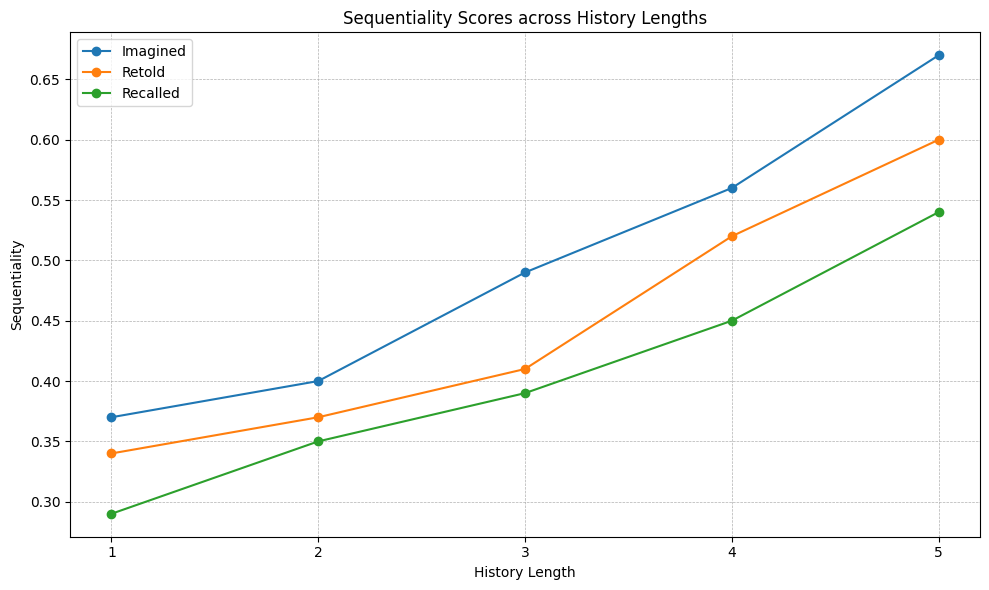

In [22]:
import matplotlib.pyplot as plt

# Data
history_sizes = [1, 2, 3, 4, 5]
imagined = [0.37, 0.4, 0.49, 0.56, 0.67]
retold = [0.34, 0.37, 0.41, 0.52, 0.60]
recalled = [0.29, 0.35, 0.39, 0.45, 0.54]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(history_sizes, imagined, '-o', label="Imagined")
plt.plot(history_sizes, retold, '-o', label="Retold")
plt.plot(history_sizes, recalled, '-o', label="Recalled")

# Formatting
plt.title("Sequentiality Scores across History Lengths")
plt.xlabel("History Length")
plt.ylabel("Sequentiality")
plt.xticks(history_sizes)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


memType
imagined    0.407905
recalled    0.433822
retold      0.418582
Name: proportion_realis, dtype: float64


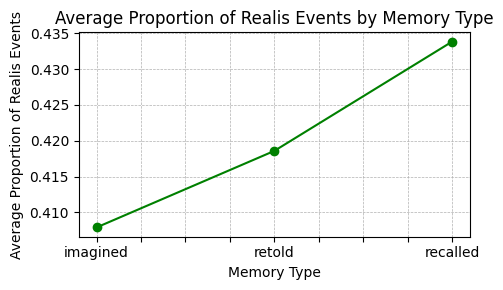

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import nltk

# Download the punkt tokenizer models
nltk.download('punkt')

# Make sure to download the averaged_perceptron_tagger from nltk
nltk.download('averaged_perceptron_tagger')

# Load data
data_frame = pd.read_csv("hcV3-stories.csv")

# Function to compute the proportion of realis events in a story
def proportion_realis_events(story_text):
    tokens = word_tokenize(story_text)
    tags = nltk.pos_tag(tokens)
    total_verb_count = sum(1 for word, pos in tags if "VB" in pos)
    past_tense_verb_count = sum(1 for word, pos in tags if pos == "VBD")

    if total_verb_count == 0:  # To prevent division by zero
        return 0
    return past_tense_verb_count / total_verb_count

# Apply the function to each story
data_frame["proportion_realis"] = data_frame["story"].apply(proportion_realis_events)

# Compute the average proportion of realis events by memory type
average_realis_proportion = data_frame.groupby("memType")["proportion_realis"].mean()

# Print the computed average proportions
print(average_realis_proportion)

# Reorder the average_realis_proportion based on the desired order
desired_order = ["imagined", "retold", "recalled"]
average_realis_proportion = average_realis_proportion.reindex(desired_order)

# Plotting without setting y-axis limits
plt.figure(figsize=(5, 3))
average_realis_proportion.plot(kind="line", marker="o", color="g")
plt.title("Average Proportion of Realis Events by Memory Type")
plt.ylabel("Average Proportion of Realis Events")
plt.xlabel("Memory Type")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


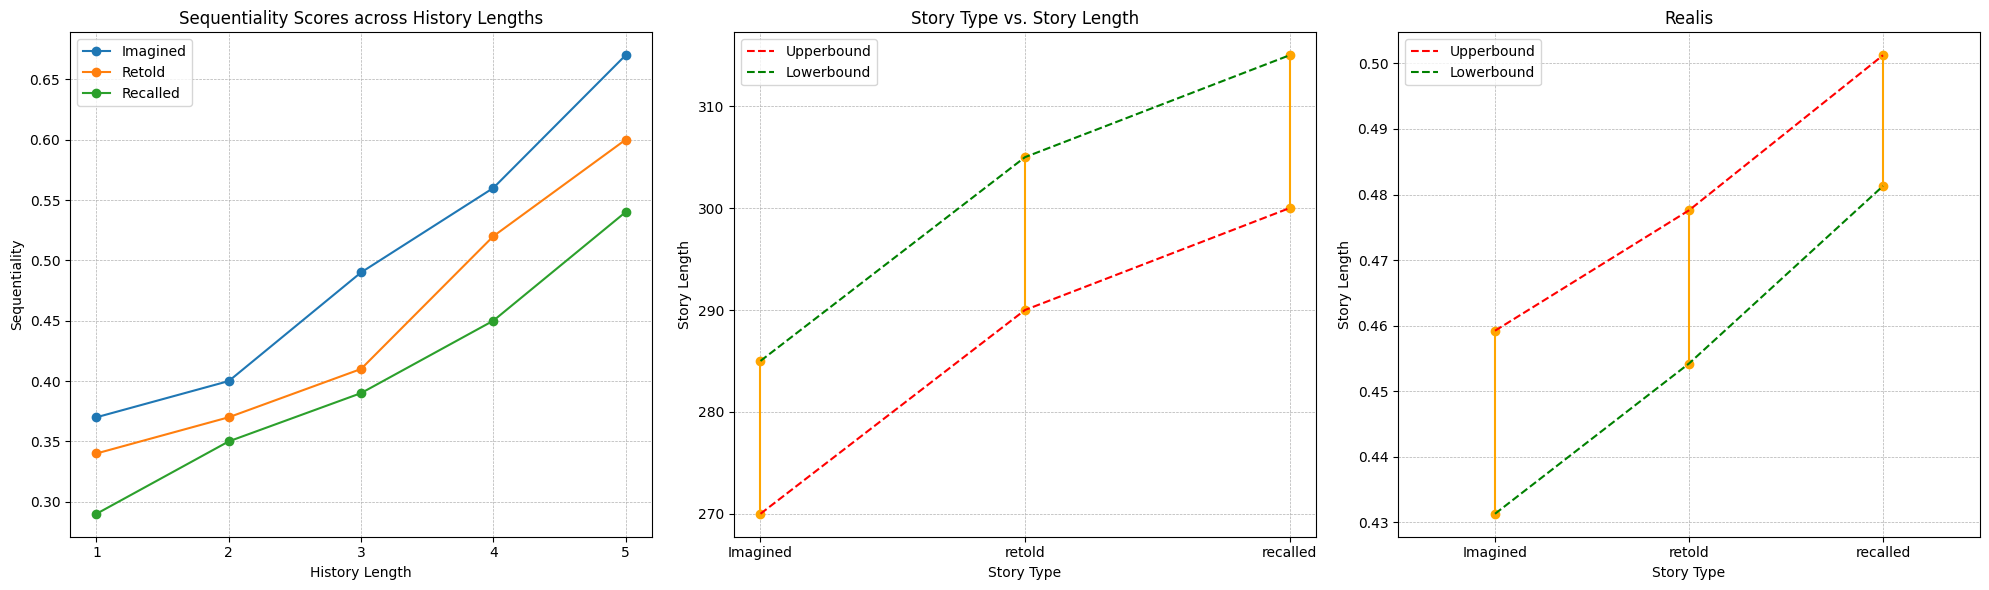

In [11]:
import matplotlib.pyplot as plt

# Data for Graph 1
history_sizes = [1, 2, 3, 4, 5]
imagined = [0.37, 0.4, 0.49, 0.56, 0.67]
retold = [0.34, 0.37, 0.41, 0.52, 0.60]
recalled = [0.29, 0.35, 0.39, 0.45, 0.54]

# Data for Graph 2 and 3
story_types = ['Imagined', 'retold', 'recalled']
upperbounds_graph2 = [270, 290, 300]
lowerbounds_graph2 = [285, 305, 315]
lowerbounds_graph3 = [0.43132, 0.45423, 0.48129]
upperbounds_graph3 = [0.45923, 0.47759, 0.50123]

# Create 1x3 grid of plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Graph 1
axes[0].plot(history_sizes, imagined, '-o', label="Imagined")
axes[0].plot(history_sizes, retold, '-o', label="Retold")
axes[0].plot(history_sizes, recalled, '-o', label="Recalled")
axes[0].set_title("Sequentiality Scores across History Lengths")
axes[0].set_xlabel("History Length")
axes[0].set_ylabel("Sequentiality")
axes[0].set_xticks(history_sizes)
axes[0].legend()
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Graph 2
for stype, upper, lower in zip(story_types, upperbounds_graph2, lowerbounds_graph2):
    axes[1].plot([stype, stype], [upper, lower], color='orange', marker='o')
axes[1].plot(story_types, upperbounds_graph2, color='red', label='Upperbound', linestyle='--')
axes[1].plot(story_types, lowerbounds_graph2, color='green', label='Lowerbound', linestyle='--')
axes[1].set_title("Story Type vs. Story Length")
axes[1].set_xlabel("Story Type")
axes[1].set_ylabel("Story Length")
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Graph 3
for stype, upper, lower in zip(story_types, upperbounds_graph3, lowerbounds_graph3):
    axes[2].plot([stype, stype], [upper, lower], color='orange', marker='o')
axes[2].plot(story_types, upperbounds_graph3, color='red', label='Upperbound', linestyle='--')
axes[2].plot(story_types, lowerbounds_graph3, color='green', label='Lowerbound', linestyle='--')
axes[2].set_xlim(-0.5, 2.5)
axes[2].set_title("Realis")
axes[2].set_xlabel("Story Type")
axes[2].set_ylabel("Story Length")
axes[2].legend()
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()


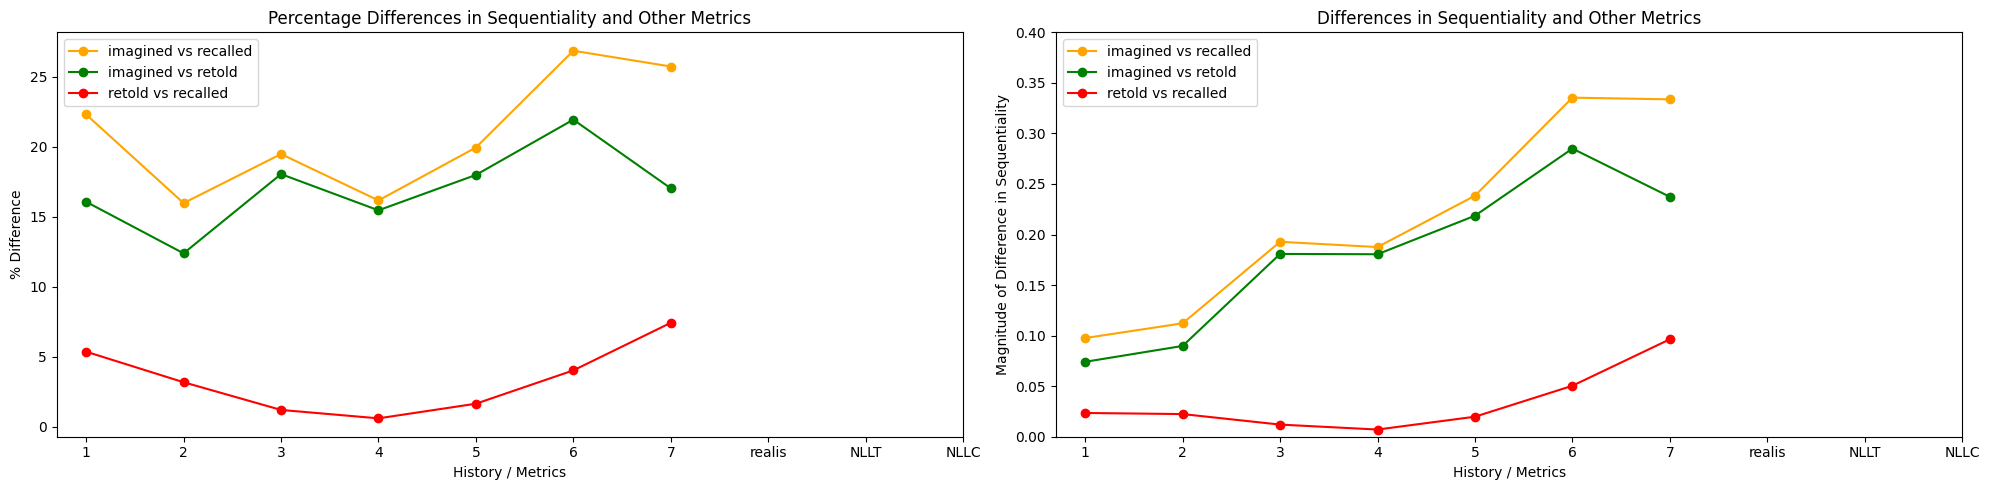

In [12]:
import matplotlib.pyplot as plt

# Renaming for clarity
sequentiality_data = {
    'imagined': [0.5351, 0.8143, 1.1824, 1.3476, 1.4335, 1.5840, 1.6304],
    'retold': [0.4610, 0.7245, 1.0016, 1.1671, 1.2149, 1.2990, 1.3931],
    'recalled': [0.4375, 0.7021, 0.9896, 1.16, 1.1951, 1.2486, 1.2967]
}
realis_proportions = {
    'imagined': 0.300518,
    'recalled': 0.34489,
    'retold': 0.327473
}

comparison_pairs = [
    ('imagined', 'recalled'),
    ('imagined', 'retold'),
    ('retold', 'recalled')
]

def compute_differences(data, pairs, use_percentage=True):
    history_lengths = list(range(1, 8))
    differences = {}
    for pair in pairs:
        topic_a, topic_b = pair
        current_diffs = {}
        for history in history_lengths:
            if use_percentage:
                difference = ((data[topic_a][history - 1] - data[topic_b][history - 1]) / data[topic_b][history - 1]) * 100
            else:
                difference = abs(data[topic_a][history - 1] - data[topic_b][history - 1])  # Absolute difference
            current_diffs[history] = abs(difference) if use_percentage else difference
        differences[pair] = current_diffs
    return differences

percentage_differences = compute_differences(sequentiality_data, comparison_pairs, use_percentage=True)
absolute_differences = compute_differences(sequentiality_data, comparison_pairs, use_percentage=False)

# Plotting the graphs side by side
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 5))
plot_colors = ['orange', 'green', 'red']
history_lengths = list(range(1, 8))
metric_labels = ['realis', 'NLLT', 'NLLC']

# Graph 1: Percentage Differences
for pair, color in zip(comparison_pairs, plot_colors):
    values = [percentage_differences[pair][history] for history in history_lengths]
    axis1.plot(history_lengths, values, '-o', label=f'{pair[0]} vs {pair[1]}', color=color)

axis1.set_xticks(list(range(1, 11)))
axis1.set_xticklabels(history_lengths + metric_labels)
axis1.set_xlabel('History / Metrics')
axis1.set_ylabel('% Difference')
axis1.set_title('Percentage Differences in Sequentiality and Other Metrics')
axis1.legend(loc='upper left')

# Graph 2: Absolute Differences
for pair, color in zip(comparison_pairs, plot_colors):
    values = [absolute_differences[pair][history] for history in history_lengths]
    axis2.plot(history_lengths, values, '-o', label=f'{pair[0]} vs {pair[1]}', color=color)

axis2.set_xticks(list(range(1, 11)))
axis2.set_xticklabels(history_lengths + metric_labels)
axis2.set_xlabel('History / Metrics')
axis2.set_ylabel('Magnitude of Difference in Sequentiality')
axis2.set_title('Differences in Sequentiality and Other Metrics')
axis2.legend(loc='upper left')
axis2.set_ylim(0.0, 0.4)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm.notebook import tqdm

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()

def compute_likelihood(sentence, context=None):
    if context:
        input_text = context + ' ' + sentence
    else:
        input_text = sentence

    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    with torch.no_grad():
        outputs = model(input_ids)
        log_likelihood = outputs[0][0, :-1].gather(1, input_ids[0, 1:].unsqueeze(-1)).sum().item()

    return log_likelihood

def calculate_sequentiality(story, summary):
    sentences = story.split('.')
    sequentiality_data = []

    for idx, sentence in enumerate(sentences):
        context = '.'.join(sentences[:idx])
        sentence_length = len(sentence.split())

        if sentence_length == 0:
            continue

        contextual_likelihood = compute_likelihood(sentence, context) / sentence_length
        topical_likelihood = compute_likelihood(sentence, summary) / sentence_length

        sequentiality = (topical_likelihood - contextual_likelihood) / sentence_length

        data = {
            "sentence": sentence,
            "contextual_likelihood": contextual_likelihood,
            "topical_likelihood": topical_likelihood,
            "sequentiality": sequentiality
        }

        sequentiality_data.append(data)

    return sequentiality_data

# Load dataset
df = pd.read_csv('hcV3-stories.csv')

# Select a sample story for demonstration
sample_story = df.iloc[0]['story']
sample_summary = df.iloc[0]['summary']

# Calculate realis and sequentiality for the sample story
sequentiality_results = calculate_sequentiality(sample_story, sample_summary)

# Print the results
for result in sequentiality_results:
    print("Sentence:", result["sentence"])
    print("Contextual Likelihood:", result["contextual_likelihood"])
    print("Topical Likelihood:", result["topical_likelihood"])
    print("Sequentiality:", result["sequentiality"])
    print("-" * 50)

# If you want to save the results to a CSV:
results_df = pd.DataFrame(sequentiality_results)
results_df.to_csv('sequentiality_results.csv', index=False)


Sentence: Concerts are my most favorite thing, and my boyfriend knew it
Contextual Likelihood: -115.11762029474431
Topical Likelihood: -432.65261008522725
Sequentiality: -26.242561139709334
--------------------------------------------------
Sentence:  That's why, for our anniversary, he got me tickets to see my favorite artist
Contextual Likelihood: -225.33286830357142
Topical Likelihood: -360.5358189174107
Sequentiality: -6.898109725195882
--------------------------------------------------
Sentence:  Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium
Contextual Likelihood: -264.88674094460225
Topical Likelihood: -261.14109108664775
Sequentiality: 0.07738945987509306
--------------------------------------------------
Sentence:  Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends
Contextual Likelihood: -376.1002038043478
Topical Likelihood: -254.22123386548913
Sequentiality:

In [7]:
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm.notebook import tqdm

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()

def compute_likelihood(sentence, context=None):
    if context:
        input_text = context + ' ' + sentence
    else:
        input_text = sentence

    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    with torch.no_grad():
        outputs = model(input_ids)
        log_likelihood = outputs[0][0, :-1].gather(1, input_ids[0, 1:].unsqueeze(-1)).sum().item()

    return log_likelihood

def calculate_sequentiality(story, summary, memtype):
    sentences = story.split('.')
    history_lengths = [1, 2, 3, 4, 5]
    sequentiality_scores = []

    for h in history_lengths:
        total_sequentiality = 0
        for idx, sentence in enumerate(sentences):
            context = '.'.join(sentences[max(0, idx-h):idx])
            sentence_length = len(sentence.split())
            if sentence_length == 0:
                continue
            contextual_likelihood = compute_likelihood(sentence, context) / sentence_length
            topic_likelihood = compute_likelihood(sentence, summary) / sentence_length

            sequentiality = (topic_likelihood - contextual_likelihood) / sentence_length
            total_sequentiality += sequentiality

        avg_sequentiality = -total_sequentiality / len(sentences) if len(sentences) != 0 else 0
        sequentiality_scores.append(avg_sequentiality)

    print(f"For {memtype} story: {sequentiality_scores}")
    return sequentiality_scores

# Load dataset
df = pd.read_csv('hcV3-stories.csv')

# Sample size
n = 100  # Modify this as needed
df_sample = df.sample(n)

# Prepare output DataFrame
df_output = pd.DataFrame(columns=["History Length", "Imagined", "Retold", "Recalled"])

# Calculate sequentiality for each story
for index, row in tqdm(df_sample.iterrows()):
    story = row['story']
    summary = row['summary']
    memType = row['memType']

    sequentiality_scores = calculate_sequentiality(story, summary, memType)

    if memType not in df_output.columns:
        continue

    df_output[memType] = sequentiality_scores

df_output["History Length"] = [1, 2, 3, 4, 5]
df_output.to_csv('sequentiality_by_history_length.csv', index=False)


0it [00:00, ?it/s]

For imagined story: [2.9578330399703936, -6.254714949673041, -25.863871008609756, -37.56451376355274, -44.029188212388505]
For retold story: [74.77534414468067, 61.66138895608635, 50.38718185205319, 40.847183724188035, 31.92323216630441]
For imagined story: [14.640269957189467, 2.797543744896434, -11.149587025629101, -22.715212979643038, -36.26256584692966]
For imagined story: [11.572971146522772, 2.940076251518379, -4.4703195561767775, -11.488376654139275, -18.259779997873384]
For recalled story: [38.02519907579171, 23.999029404187606, 6.342677502443762, -10.1730378150909, -21.68873312480526]
For retold story: [10.540296307923754, 3.9020613630587597, -2.1107485923062606, -8.006765540762283, -13.16847587989366]
For imagined story: [7.84937852784949, -4.927725662074344, -17.866891854316577, -32.200993683405216, -48.04588650270485]
For recalled story: [67.63255753319207, 20.50368801669397, -11.362454236904, -43.34485055961811, -81.50974332636542]
For recalled story: [12.491641848516169, 

KeyboardInterrupt: ignored